<a href="https://colab.research.google.com/github/sacktock/EDVAM-models/blob/main/LSTM_classifier_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM classifier for the EDVAM dataset**

EDVAM: the first 3D eye tracking dataset for a virtual world.
https://github.com/YunzhanZHOU/EDVAM

Best configuration of parameters found (so far):
*   Original model - with 1 LSTM cell:
  *   12 input features
  *   hidden size = 12
  *   dropout = 0.4
  *   12 output classes
*   Hyper-parameters:
  *   batch size = 32
  *   learning rate = 0.1
  *   number of epochs = 30
  *   decay learning rate by a factor of 10 every 15 epochs
  *   stochactic gradient descent (SGD) optimizer
*   Other tricks:
  *   normalize entire dataset
  *   batch normalization
  *   stochastic frame sampling - 78 frames
  *   trainable initial state
  *   set forget gate biases to 1

Results: the (best) validation accuracy acheived with this model was 74.819%














**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Dependencies**

In [2]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imports**

In [3]:
import math
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from livelossplot import PlotLosses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Hyper-params**


In [4]:
batch_size = 32
learning_rate = 0.001
n_epoch = 40

lr_halflife = 20. # learning rate decay in epochs
lr_decay_rate = .1**(1./lr_halflife) # decay by a factor of 10 after 20 epochs

**Import Dataset**

In [5]:
# only use PoG, Location and Orientation features
# fetch the training data and labels
train_set = np.load('drive/My Drive/EDVAM_practical_subset/train.npy')
train_set = np.delete(train_set, [i for i in range(9,40)], axis=2)
train_label = np.load('drive/My Drive/EDVAM_practical_subset/train_label.npy')

# fetch the test data and labels
test_set = np.load('drive/My Drive/EDVAM_practical_subset/test.npy')
test_set = np.delete(test_set, [i for i in range(9,40)], axis=2)
# split the test set into sequnces of 78 frames instead of 300
test_set = np.concatenate((test_set[:, 0:150:6 , :], test_set[:, 150:240:5, :], test_set[:, 240:290:2, :], test_set[:, 290:300, :]), axis=1)
test_label = np.load('drive/My Drive/EDVAM_practical_subset/test_label.npy')

# normalize both datasets using pre-computed means and stds
means = np.array([[[-14.37293346, 1.62620999 , -4.38974475, -16.22418695, 1.71081376, 
                    -4.03731866, 0.48303131, -0.04178857, -0.03728982]]], dtype=np.float16)

stds = np.array([[[4.06166681, 0.86760783, 2.84685403, 2.68625898, 0.06159622, 1.63527627, 0.65958249, 
                   0.18040276, 0.55574791]]], dtype=np.float16)

train_set = (train_set - means) / stds
test_set = (test_set - means) / stds

# wrap data in tensors and init data loaders
train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_label))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_label))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

dataloaders = {"train": train_loader, "test": test_loader}

**Looking at the Dataset**

In [6]:
# Visualizing the data
print('Train set size:', len(train_data))
print('Test set size:',len(test_data))
print()

print('Data item:')
print(train_data[1])
print()

print('Time window:',train_data[1][0])
print()
print('Label:',train_data[1][1])
print()

print('Time window shape', test_data[1][0].shape)
print()

print('Frame:', train_data[1][0][1])
print()
print('Frame shape', train_data[1][0][1].shape)

# Compute means and stds
arr = train_set.reshape(-1, train_set.shape[-1])
arr = arr.astype(np.float32)

print(arr.mean(axis=0))
print(arr.std(axis=0))

del arr

Train set size: 190830
Test set size: 32530

Data item:
(tensor([[-0.2269, -0.8369,  0.2072,  ...,  0.7837, -0.8770,  0.0671],
        [-0.2769,  0.3162, -0.1783,  ...,  0.7837,  0.2316, -0.2927],
        [-0.2769,  0.6606, -0.3196,  ...,  0.7837,  0.2316, -0.2927],
        ...,
        [-0.2769,  0.6606,  0.1015,  ...,  0.7837,  0.2316,  0.0671],
        [-0.2769,  0.6606,  0.1015,  ...,  0.7837,  0.2316,  0.0671],
        [-0.2769,  0.6606,  0.1015,  ...,  0.7837,  0.2316,  0.0671]],
       dtype=torch.float16), tensor(0., dtype=torch.float64))

Time window: tensor([[-0.2269, -0.8369,  0.2072,  ...,  0.7837, -0.8770,  0.0671],
        [-0.2769,  0.3162, -0.1783,  ...,  0.7837,  0.2316, -0.2927],
        [-0.2769,  0.6606, -0.3196,  ...,  0.7837,  0.2316, -0.2927],
        ...,
        [-0.2769,  0.6606,  0.1015,  ...,  0.7837,  0.2316,  0.0671],
        [-0.2769,  0.6606,  0.1015,  ...,  0.7837,  0.2316,  0.0671],
        [-0.2769,  0.6606,  0.1015,  ...,  0.7837,  0.2316,  0.0671]],

**Define the Model (original)**

In [7]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim=8, dropout=0.2):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim

    self.drop = nn.Dropout(dropout)
    self.lstm = nn.LSTMCell(input_size, hidden_dim)
    self.linear = nn.Linear(hidden_dim, output_size)


    self.init_weights()
    self.init_hidden()

  def init_weights(self):
    # init the weights of the linear classifier
    initrange = 0.1
    self.linear.bias.data.zero_()
    self.linear.weight.data.uniform_(-initrange, initrange)

    # set the forget gate bias to 1
    n = self.lstm.bias_hh.size(0)
    start, end = n//4, n//2
    self.lstm.bias_hh.data[start:end].fill_(1.)

    n = self.lstm.bias_ih.size(0)
    start, end = n//4, n//2
    self.lstm.bias_ih.data[start:end].fill_(1.)

  def init_hidden(self):
    # init the trainable initial hidden state
    h0 = torch.zeros(1, self.hidden_dim).to(device)
    c0 = torch.zeros(1, self.hidden_dim).to(device)
    nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
    self.h0 = nn.Parameter(h0, requires_grad=True) 
    self.c0 = nn.Parameter(c0, requires_grad=True)

  def forward(self, input, future=1):
    input = input.float()
    batch_size = input.shape[0]

    # initial hidden state 
    h_t, c_t = (self.h0.repeat(batch_size, 1), self.c0.repeat(batch_size, 1))

    for i, input in enumerate(input.chunk(input.size(1), dim=1)):
      h_t, c_t = self.lstm(input.squeeze(), (h_t, c_t))

    output = self.linear(self.drop(h_t))

    return output

input_size = 9
output_size = 12

model = LSTMModel(input_size, output_size).to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
liveplot = PlotLosses()

**Define the Model (new)**

In [8]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim=9, num_layers=3, dropout=0.2):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.drop = nn.Dropout(dropout)
    self.lstm = nn.LSTM(self.input_size, self.hidden_dim, self.num_layers, dropout=dropout, batch_first=True)
    self.linear = nn.Linear(self.hidden_dim, self.output_size)

    self.init_weights()
    self.init_hidden()

  def init_weights(self):
    initrange = 0.1
    self.linear.bias.data.zero_()
    self.linear.weight.data.uniform_(-initrange, initrange)

    # set the forget gate bias to 1
    for names in self.lstm._all_weights:
      for name in filter(lambda n: "bias" in n,  names):
          bias = getattr(self.lstm, name)
          n = bias.size(0)
          start, end = n//4, n//2
          bias.data[start:end].fill_(1.)

  def init_hidden(self):
    # init the trainable initial hidden state
    h0 = torch.zeros(self.num_layers, 1, self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers, 1, self.hidden_dim).to(device)
    nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
    self.h0 = nn.Parameter(h0, requires_grad=True)  # Parameter() to update weights
    self.c0 = nn.Parameter(c0, requires_grad=True)
    
  def forward(self, input, future=1):
    input = input.float()
    batch_size = input.shape[0]
    
    # initial hidden state 
    hidden = (self.h0.repeat(1, batch_size, 1), self.c0.repeat(1, batch_size, 1))

    lstm_out, _ = self.lstm(input, hidden)
    last_lstm_out = lstm_out[:, -1, :].view(-1, self.hidden_dim)

    output = self.linear(self.drop(last_lstm_out))
    return output

input_size = 9
output_size = 12

model = LSTMModel(input_size, output_size).to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
liveplot = PlotLosses()

**Training Code**

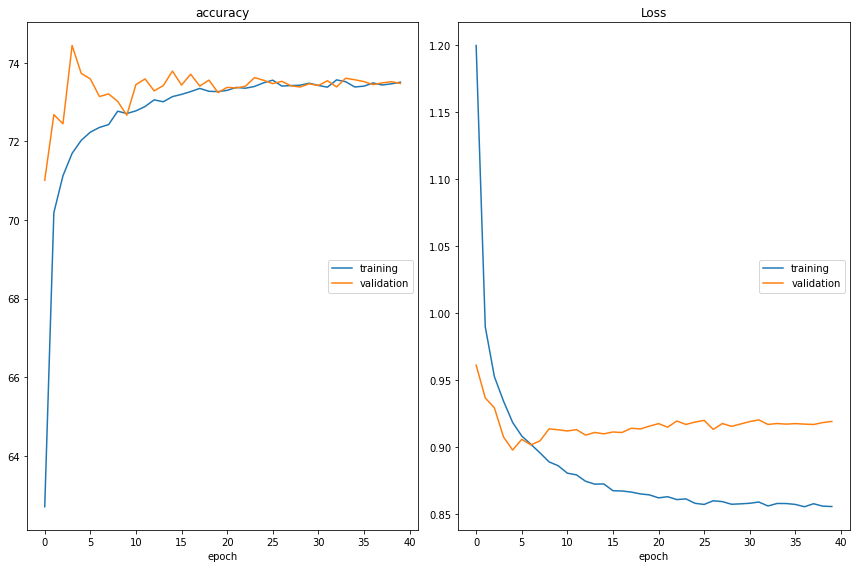

accuracy
	training         	 (min:   62.703, max:   73.566, cur:   73.507)
	validation       	 (min:   71.011, max:   74.442, cur:   73.477)
Loss
	training         	 (min:    0.855, max:    1.200, cur:    0.856)
	validation       	 (min:    0.898, max:    0.961, cur:    0.919)
Epoch 40/40


In [9]:
# helper function so set learning rate
def set_lr(lr):
  for param_group in optim.param_groups:
    param_group['lr'] = lr

epoch = 0
best_val_acc = -np.inf

while (epoch < n_epoch):
  epoch_loss = {}
  epoch_acc = {}
  for phase in ["train", "test"]:
    if phase == "train":
      model.train()
    else:
      model.eval()

    losses = 0
    correct = 0
    total = 0
  
    for batch_data, labels in dataloaders[phase]:
      batch_data, labels = batch_data.to(device), labels.to(device)

      if phase == "train":
        # stochastic frame sampling
        batch_data = torch.cat((batch_data[:, np.sort(np.random.choice([i for i in range(0,150)], 25, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(150,240)], 18, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(240,290)], 25, replace=False)), :], 
                              batch_data[:, 290:300, :]), dim=1)
      
        # batch normalization
        flat_data = batch_data.reshape(-1, batch_data.shape[-1])
      
        batch_means = torch.mean(flat_data, 0).view(1,1,-1)
        batch_stds = torch.std(flat_data, 0).view(1,1,-1)
        batch_stds = batch_stds.masked_fill(batch_stds == 0.0, 0.001)

        batch_data = (batch_data - batch_means) / batch_stds

        if torch.isnan(batch_data).any():
          print("error")
      
      output = model(batch_data)
      loss = nn.CrossEntropyLoss()(output.squeeze(), labels.long())

      # parameter update step
      if phase == "train":
        optim.zero_grad()
        loss.backward()
        optim.step()

      _, predicted = torch.max(output, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
      losses += loss.item() * labels.shape[0]

    epoch_acc[phase] = 100*(correct / total)
    epoch_loss[phase] = losses / total

    if phase == "test" and epoch_acc[phase] > best_val_acc:
      best_val_acc = epoch_acc[phase]
      torch.save({'model':model.state_dict()}, 'drive/My Drive/training/LSTM.chkpt')

  epoch += 1
  
  learning_rate *= lr_decay_rate
  set_lr(learning_rate)
  
  liveplot.update({"loss" : epoch_loss["train"], "val_loss" : epoch_loss["test"], "accuracy" : epoch_acc["train"], "val_accuracy" : epoch_acc["test"]})
  liveplot.send()
  print('Epoch {}/{}'.format(epoch, n_epoch))

**Model Validation**

In [10]:
try:
  params = torch.load('drive/My Drive/training/LSTM.chkpt')
  model.load_state_dict(params['model'])
except:
  print('Failed to load best model ... using current model')

model.eval()

with torch.no_grad():
  for phase in ["train", "test"]:
    correct = 0
    total = 0
    for batch_data, labels in dataloaders[phase]:
      batch_data, labels = batch_data.to(device), labels.to(device).long()

      if phase == "train":
        # stochastic frame sampling
        batch_data = torch.cat((batch_data[:, np.sort(np.random.choice([i for i in range(0,150)], 25, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(150,240)], 18, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(240,290)], 25, replace=False)), :], 
                              batch_data[:, 290:300, :]), dim=1)

      output = model(batch_data)

      _, predicted = torch.max(output, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())

    print(f"Model ({phase}) accuracy: {100*(correct / total)}%")

Model (train) accuracy: 74.90042763709542%
Model (test) accuracy: 74.442053489087%


# Evaluate the model
Let's have a look at some regression metrics and accuracy scores for each of the features.

*   First we need to create a label map, each label maps to a vector with average PoG, Position and Orientation values for the corresponding label.


In [11]:
dataset = []

# read in data from the raw EDVAM dataset with labels
for num in range(1, 64):
  dataset.append(np.array(pd.DataFrame(pd.read_csv('drive/My Drive/raw_subset_withLabel/'+str(num)+'.csv', header=0)).iloc[:,2:13]))

full_set = []
for num in range(0, 63):
  full_set.extend(np.array(dataset[num]))

full_set = np.array(full_set)

full_set = np.concatenate((full_set[:, 0:10], np.expand_dims(full_set[:, 10] -1.0, axis=1)), axis=1)

label_map = {}

# compute average vector values using the full dataset
for label in range(0, 12):
  rows = np.where(full_set[:,10]==label)
  label_set = full_set[rows]
  label_avg = np.mean(label_set, axis=0)
  label_avg = label_avg[0:9]
  label_map[label] = label_avg

# let's have a look at the label map
print(label_map)

{0: array([-14.20486443,   2.28719982,  -4.61343586, -17.88697425,
         1.71605149,  -4.26571429,   0.88706083,   0.07421508,
        -0.05571429]), 1: array([-11.09307856,   1.52615823,  -4.24337597, -15.68323327,
         1.7073138 ,  -3.97286995,   0.91759753,  -0.03959479,
        -0.06265604]), 2: array([-15.14981965,   0.79946313,  -4.49104941, -17.21259961,
         1.69526885,  -4.1145877 ,   0.80323798,  -0.25309957,
        -0.10994883]), 3: array([-15.42866836,   0.37659033,  -4.37336726, -16.92748092,
         1.70695505,  -3.9648855 ,   0.4163698 ,  -0.28871925,
        -0.05903308]), 4: array([-21.59088879,   1.467947  ,  -4.64847402, -17.11172771,
         1.71855739,  -4.22609796,  -0.72114039,  -0.06250186,
        -0.06754503]), 5: array([-16.23116505,   2.86087379,  -2.5938835 , -17.69796117,
         1.72436893,  -4.9576699 ,   0.2207767 ,   0.17320388,
         0.48699029]), 6: array([-11.61139923,   1.56813864,  -5.44424904, -14.79464698,
         1.71263158, 



*   Load in the raw dataset to use the same inputs and targets for evaluation as the seq2seq models.



In [12]:
dataset = []

# read in data from the raw EDVAM dataset
for num in range(1, 64):
  dataset.append(np.array(pd.DataFrame(pd.read_csv('drive/My Drive/EDVAM_raw_subset/'+str(num)+'.csv', header=0)).iloc[:,2:11]))

test_ids = [54, 40, 38, 52, 62, 58, 46, 12, 24]

SEQ_LEN = 300
BATCH_SIZE = 128

In [41]:
model.eval()

futures = [1, 5, 10, 45, 90] # how good is the model at predicting into the future

df_m = pd.DataFrame(index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
df_p = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_c = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_v = pd.DataFrame(index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])

for future in futures:
  actual, predicted = [], []

  with torch.no_grad():
    for idx in test_ids:
      for start in range(0, dataset[idx].shape[0] - SEQ_LEN - BATCH_SIZE - future, BATCH_SIZE):
        inputs = np.array([np.array(dataset[idx][start+i:start+i+SEQ_LEN, :], dtype=np.float32) for i in range(BATCH_SIZE)])
        targets = np.array([np.array(dataset[idx][start+i+SEQ_LEN+future-1, :], dtype=np.float32)for i in range(BATCH_SIZE)])
        # split the test set into sequnces of 78 frames instead of 300
        inputs = np.concatenate((inputs[:, 0:150:6 , :], inputs[:, 150:240:5, :], inputs[:, 240:290:2, :], inputs[:, 290:300, :]), axis=1)
        # transform input
        inputs = (inputs - means) / stds
        inputs = torch.tensor(inputs).to(device)

        # get the predicted labels
        outputs = model(inputs, future=future)
        _, pred_labels = torch.max(outputs, dim=1)
        pred_labels = pred_labels.data.cpu().numpy()
        
        # map the predicted labels to predicted PoG, Pos and Orientation values
        outputs = np.zeros_like(targets)
        for index, label in enumerate(pred_labels):
          outputs[index, :] = label_map[label]

        predicted += outputs.tolist()

        actual += targets.tolist()

  actual, predicted = np.array(actual), np.array(predicted)

  N = actual.shape[0]

  # point of gaze accuracy measures (in meters)
  pog_error = np.sqrt(np.square(actual - predicted)[:, 0:3].sum(axis=1))
  pog_accuracy = [100 * np.array([1 if error < dist else 0 for error in pog_error]).sum() / N for dist in [.5, 1., 2., 5.]]

  # camera position accuracy measures (in meters)
  cam_error = np.sqrt(np.square(actual - predicted)[:, 3:6].sum(axis=1))
  cam_accuracy = [100 * np.array([1 if error < dist else 0 for error in cam_error]).sum() / N  for dist in [.5, 1., 2., 5.]]

  # camera orientation error (in degrees)
  vec_error = np.arccos((actual[:, 6] * predicted[:, 6] + actual[:, 7] * predicted[:, 7] + actual[:, 8] * predicted[:, 8])
              / (np.sqrt(actual[:, 6]**2 + actual[:, 7]**2 + actual[:, 8]**2) * np.sqrt(predicted[:, 6]**2 + predicted[:, 7]**2 + predicted[:, 8]**2)))
  # convert from radians to degrees
  vec_error = vec_error * 180 / np.pi
  vec_error = [100 * np.array([1 if error < angle else 0 for error in vec_error]).sum() / N  for angle in [1., 5., 10., 30.]]

  # regression metrics
  MSE = (np.square(actual - predicted)).mean(axis=0) # mean squared error
  MAE = (np.abs(actual - predicted)).mean(axis=0) # mean absolute error
                    
  # adjusted R squared correlation coeff for multiple regression
  # each feature is dependent on each feature, but some features are correlated
  N = predicted.shape[0]
  k = predicted.shape[1]
  adj_R2 = []
  # add a small amount of Guassian noise so the correlation matrix is invertible
  predicted += np.random.randn(*predicted.shape) * 1e-5
  corr_matrix = np.corrcoef(predicted, rowvar=False)
  for i in range(k):
    corr_yi = np.corrcoef(predicted, actual[:, i], rowvar=False)
    corr_vec = [corr_yi[j][9] for j in range(k)]

    R2 = np.dot(np.dot(corr_vec, np.linalg.inv(corr_matrix)), corr_vec)

    adj_R2 += [1 - (1 - R2)*((N - 1) / (N - k - 1))]

  df = pd.DataFrame({"MSE" : MSE, "MAE" : MAE, "adj R2" : adj_R2}, 
                    index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
  df_m = pd.concat([df_m, df], axis=1)

  df = pd.DataFrame({"PoG accuracy" : pog_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_p = pd.concat([df_p, df], axis=1)

  df = pd.DataFrame({"Camera accuracy": cam_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_c = pd.concat([df_c, df], axis=1)

  df = pd.DataFrame({"Camera vec accuracy" : vec_error}, index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])
  df_v = pd.concat([df_v, df], axis=1)

**Model prediction metrics**

In [43]:
pd.set_option("display.precision", 5)
df_m.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['MSE', 'MAE', 'R2']])
display(df_m)

1 futures                   5 futures                   10 futures  \
                MSE      MAE       R2       MSE      MAE       R2        MSE   
PoG X       4.18571  1.57989  0.80086   4.56540  1.63908  0.78105    4.92830   
PoG Y       0.85492  0.74755  0.15582   0.85974  0.74937  0.13793    0.85589   
PoG Z       2.64377  1.09603  0.70552   2.74912  1.12074  0.69492    2.85400   
Cam X       7.33238  2.14746  0.19178   7.35451  2.15434  0.19249    7.39456   
Cam Y       0.00044  0.01441  0.10431   0.00044  0.01440  0.10705    0.00044   
Cam Z       2.44223  1.23695  0.28302   2.44090  1.23647  0.28606    2.41731   
Cam Vec X   0.18414  0.30016  0.67962   0.18866  0.30396  0.67216    0.19544   
Cam Vec Y   0.02562  0.12765  0.15815   0.02569  0.12785  0.15135    0.02572   
Cam Vec Z   0.12180  0.26115  0.68654   0.12411  0.26389  0.68154    0.12784   

                            45 futures                   90 futures           \
               MAE       R2        MSE      MAE       R2        MSE      MAE   
PoG X      1.69495  0.75873    7.08872  2.00960  0.65200    9.71619  2.35015   
PoG Y      0.74731  0.13184    0.88547  0.75859  0.09126    0.93226  0.78075   
PoG Z      1.14381  0.68538    3.61756  1.29623  0.60153    4.63509  1.50866   
Cam X      2.16187  0.19105    7.31988  2.15177  0.20772    7.26859  2.16540   
Cam Y      0.01437  0.10295    0.00044  0.01436  0.07523    0.00043  0.01432   
Cam Z      1.22997  0.29719    2.37099  1.21255  0.32397    2.37257  1.20448   
Cam Vec X  0.30884  0.65598    0.24850  0.34853  0.57024    0.32165  0.39892   
Cam Vec Y  0.12781  0.15089    0.02649  0.12956  0.11151    0.02803  0.13239   
Cam Vec Z  0.26789  0.67344    0.16149  0.30077  0.57993    0.20824  0.34339   

                    
                R2  
PoG X      0.53888  
PoG Y      0.06483  
PoG Z      0.50225  
Cam X      0.22201  
Cam Y      0.03961  
Cam Z      0.33063  
Cam Vec X  0.45944  
Cam Vec Y  0.07335  
Cam Vec Z  0.46092

**Model prediction accuracy for PoG in 3D world coordinates**

In [44]:
pd.set_option("display.precision", 2)
df_p.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['PoG accuracy']])
display(df_p)

,1 futures,5 futures,10 futures,45 futures,90 futures
,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy
<.5m,6.09,6.01,5.93,4.93,3.99
<1m,17.28,16.93,16.67,14.21,12.10
<2m,46.90,45.47,44.49,38.45,32.46
<5m,94.92,94.06,93.10,87.53,80.64


**Model prediction accuracy for Camera position in 3D world coordinates**

In [45]:
df_c.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera position accuracy']])
display(df_c)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy
<.5m,2.67,2.65,2.67,2.73,2.39
<1m,10.86,10.56,10.35,10.98,10.29
<2m,36.30,36.22,36.28,37.38,36.32
<5m,92.50,92.52,92.50,92.70,92.86


**Model prediction accuracy for Camera position in 3D world coordinates**

In [46]:
df_v.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera vec accuracy']])
display(df_v)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy
<1 deg,0.25,0.25,0.25,0.23,0.12
<5 deg,7.45,7.32,7.24,6.49,5.41
<10 deg,25.12,24.82,24.78,23.08,20.29
<30 deg,65.28,64.77,63.94,59.00,52.72
